In [1]:
import sys
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# install uplift library scikit-uplift and other libraries 
#!{sys.executable} -m pip install scikit-uplift dill catboost

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load Dataset

We are going to use a Hillstrom dataset from the MineThatData [hosted](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html) in march 2008 by the president of this company Kevin Hillstrom.

MineThatData is a consulting company that helps CEO understand the complex relationship between Customers, Advertising, Products, Brands, and Channels.

## Data description

Dataset can be loaded from sklift.datasets module using fetch_hillstrom function.

Read more about dataset in the [api docs](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_hillstrom.html).

This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test

**Major columns**

- **visit** (binary): target. 1/0 indicator, 1 = Customer visited website in the following two weeks.

- **conversion** (binary): target. 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.

- **spend** (float): target. Actual dollars spent in the following two weeks.

- **segment** (str): treatment. The e-mail campaign the customer received

Read more in the [docs](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_hillstrom.html#hillstrom)

In [2]:
from sklift.datasets import fetch_hillstrom

# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 
dataset = fetch_hillstrom()

In [3]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (64000, 8)
Dataset target shape: (64000,)
Dataset treatment shape: (64000,)


## EDA 

In [4]:
dataset.data.head().append(dataset.data.tail())

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel
63999,1,4) $350 - $500,472.82,0,1,Surburban,0,Web


In [5]:
#info about types and null cells in dataset
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 8 columns):
recency            64000 non-null int64
history_segment    64000 non-null object
history            64000 non-null float64
mens               64000 non-null int64
womens             64000 non-null int64
zip_code           64000 non-null object
newbie             64000 non-null int64
channel            64000 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 3.9+ MB


There is no missing data in the cells! 

# Categorical data

In [6]:
cat_features = ['channel', 'zip_code', 'history_segment', 'newbie']

In [7]:
dataset.data.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [8]:
dataset.data.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [9]:
dataset.data.history_segment.unique()

array(['2) $100 - $200', '3) $200 - $350', '5) $500 - $750',
       '1) $0 - $100', '6) $750 - $1,000', '4) $350 - $500',
       '7) $1,000 +'], dtype=object)

**Zip code**

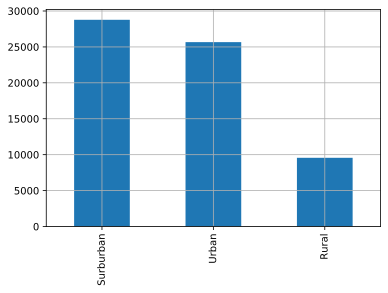

In [10]:
dataset.data.zip_code.value_counts().plot(kind = 'bar', grid=True)

**Channel**

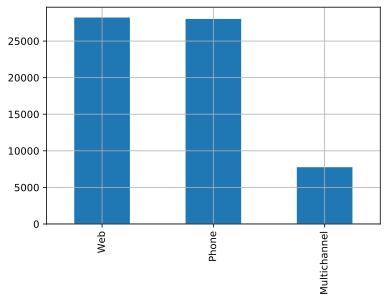

In [11]:
dataset.data.channel.value_counts().plot(kind = 'bar', grid=True)

**History segment**

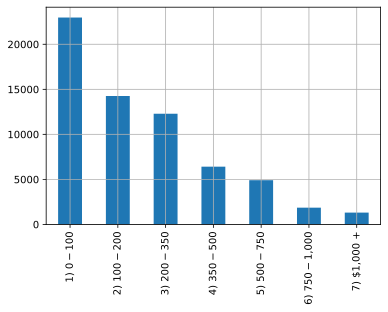

In [12]:
dataset.data.history_segment.value_counts().plot(kind = 'bar', grid=True)

In [13]:
for payment in dataset.data['history_segment'].unique(): 
    if payment =='1) $0 - $100':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 50
    elif payment =='2) $100 - $200':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 150
    elif payment =='3) $200 - $350':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 275
    elif payment =='4) $350 - $500':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 425
    elif payment =='5) $500 - $750':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 575
    elif payment =='5) $750 - $1000':
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 825
    else:
        dataset.data.loc[dataset.data['history_segment'] == payment, 'history_segment'] = 1000

In [14]:
dataset.data.history_segment.value_counts()

50      22970
150     14254
275     12289
425      6409
575      4911
1000     3167
Name: history_segment, dtype: int64

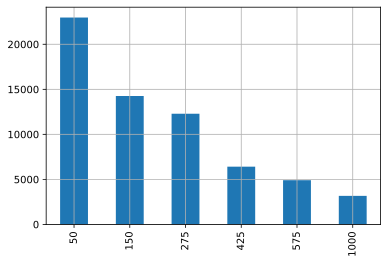

In [15]:
dataset.data.history_segment.value_counts().plot(kind = 'bar', grid=True)

In [16]:
#It's better to proceed from categorical to numeric data
# For example, we could replace 0-100 on average value 50 

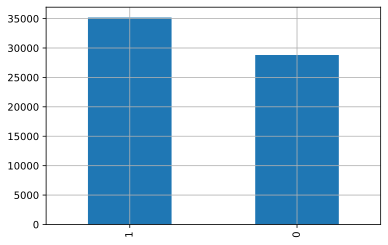

In [17]:
dataset.data.womens.value_counts().plot(kind = 'bar', grid=True)

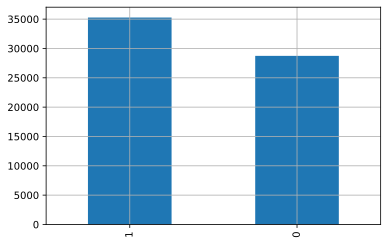

In [18]:
dataset.data.mens.value_counts().plot(kind = 'bar', grid=True)

In [19]:
dataset.data.womens.value_counts()

1    35182
0    28818
Name: womens, dtype: int64

In [20]:
dataset.data.mens.value_counts()

1    35266
0    28734
Name: mens, dtype: int64

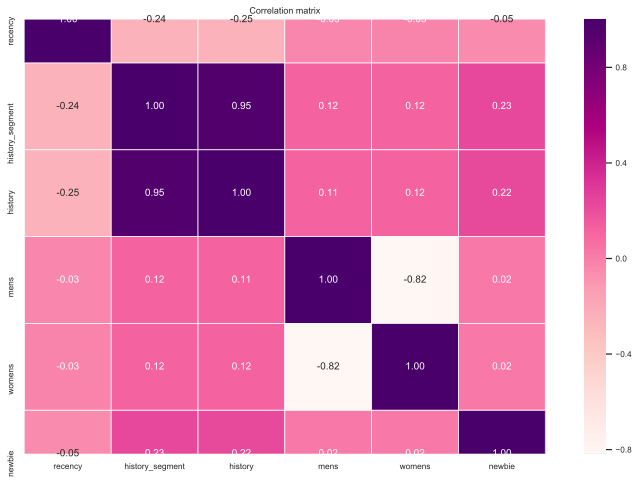

In [21]:
plt.figure(figsize = (14,8))

sns.set(font_scale=0.75)
sns.heatmap(dataset.data.corr().round(3), annot=True, square = True, linewidths=.75, cmap='RdPu', fmt = '.2f',annot_kws = {"size": 10} )

plt.title('Correlation matrix')
plt.show()


In [22]:
# womens and mens are in inverse correlation. I propose to make 1 column "gender" and merge.

In [23]:
# As we can see, there is high correlation between 'history_segment' and 'history'. Could we merge it?  

# Numeric data

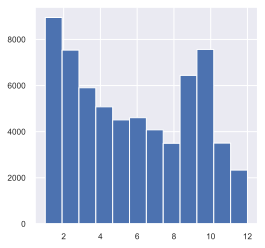

In [24]:
dataset.data.loc[:, 'recency'].hist(figsize=(4, 4), bins=12, grid=True);

In [25]:
dataset.data.history.value_counts()

29.99     7947
81.20        9
53.79        9
142.94       8
35.40        8
          ... 
701.66       1
246.45       1
798.83       1
125.19       1
104.00       1
Name: history, Length: 34833, dtype: int64

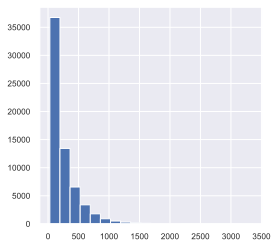

In [26]:
dataset.data.loc[:, 'history'].hist(figsize=(4, 4), bins=20, grid=True);

# Target data

In [27]:
#dataset_segment
dataset.treatment.head()

0    Womens E-Mail
1        No E-Mail
2    Womens E-Mail
3      Mens E-Mail
4    Womens E-Mail
Name: segment, dtype: object

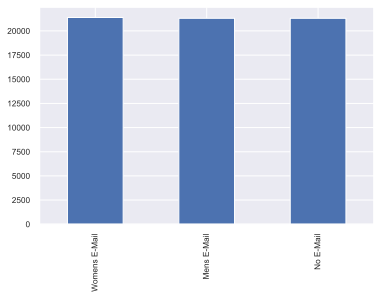

In [32]:
dataset.treatment.value_counts().plot(kind = 'bar', grid = 'True')

In [28]:
#dataset_visit
dataset.target.head()

0    0
1    0
2    0
3    0
4    0
Name: visit, dtype: int64

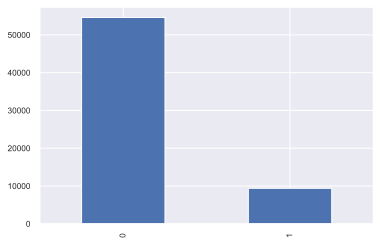

In [30]:
dataset.target.value_counts().plot(kind = 'bar')

In [ ]:
#Target is disbalanced

In [ ]:
import pandas as pd 

pd.crosstab(dataset.treatment, dataset.target, normalize='index')

In [ ]:
# make treatment binary
#treat_dict = {
#    'Womens E-Mail': 1,
#    'No E-Mail': 0, 
#    'Mens E-Mail': -1
#}
#dataset.treatment = dataset.treatment.map(treat_dict)

Text(0.5, 1, 'Treatment & Target')

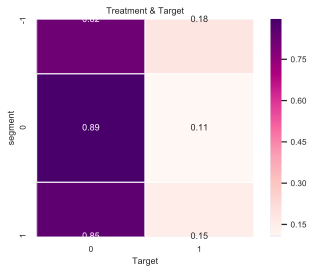

In [45]:
crosstab = pd.crosstab(dataset.treatment, dataset.target, normalize='index')
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = 'RdPu')
plt.xlabel('Target')
plt.title("Treatment & Target")

In [39]:
treat_dict = {
    'Womens E-Mail': 1,
    'No E-Mail': 0, 
    'Mens E-Mail': -1
}
dataset.treatment = dataset.treatment.map(treat_dict)

In [40]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

In [41]:
stratify_cols.head(5)

,segment,visit
0,1,0
1,0,0
2,1,0
3,-1,0
4,1,0


In [42]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (44800, 8)
Validation shape: (19200, 8)


In [43]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

estimator = CatBoostClassifier(verbose=100, 
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [ ]:
ct_model.fit(
    X=X_train, 
    y=y_train, 
    treatment=trmnt_train
)

In [ ]:
#in progress with multiclassclassifier for Catboost. 